<a href="https://colab.research.google.com/github/skck0226/2022S-ML/blob/main/baseline_ipynb%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Challenge :: Cartoon Character Classification

만화 이미지를 보고 어떤 캐릭터인지를 분류하는 테스크입니다.  
캐릭터 클래스는 총 10개 입니다.

## Download Data
데이터 출처: https://www.kaggle.com/datasets/volkandl/cartoon-classification

코랩에서 캐글 데이터셋을 바로 불러오기 위해서 kaggle.json 파일이 필요합니다.  
```캐글 본인 계정 페이지``` -> ```Account``` -> ```API``` -> ```Create New API Token```
로 kaggle.json 파일을 다운로드 받을 수 있습니다.

In [2]:
!pip install kaggle
from google.colab import files
files.upload()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"skck0226","key":"8d56c901a19f07a587d73d234002409d"}'}

In [3]:
ls -1ha kaggle.json # kaggle.json 확인

kaggle.json


In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# Permission Warning 방지
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d volkandl/cartoon-classification

100% 11.5G/11.5G [00:49<00:00, 257MB/s]
100% 11.5G/11.5G [00:49<00:00, 248MB/s]


In [6]:
!ls # 데이터셋 다운로드 확인

cartoon-classification.zip  kaggle.json  sample_data


In [7]:
!unzip cartoon-classification.zip

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: cartoon_classification/TRAIN/tom_and_jerry/TOM_AND_JERRY5099.jpg  
  inflating: cartoon_classification/TRAIN/tom_and_jerry/TOM_AND_JERRY51.jpg  
  inflating: cartoon_classification/TRAIN/tom_and_jerry/TOM_AND_JERRY510.jpg  
  inflating: cartoon_classification/TRAIN/tom_and_jerry/TOM_AND_JERRY5100.jpg  
  inflating: cartoon_classification/TRAIN/tom_and_jerry/TOM_AND_JERRY5101.jpg  
  inflating: cartoon_classification/TRAIN/tom_and_jerry/TOM_AND_JERRY5102.jpg  
  inflating: cartoon_classification/TRAIN/tom_and_jerry/TOM_AND_JERRY5103.jpg  
  inflating: cartoon_classification/TRAIN/tom_and_jerry/TOM_AND_JERRY5104.jpg  
  inflating: cartoon_classification/TRAIN/tom_and_jerry/TOM_AND_JERRY5105.jpg  
  inflating: cartoon_classification/TRAIN/tom_and_jerry/TOM_AND_JERRY5106.jpg  
  inflating: cartoon_classification/TRAIN/tom_and_jerry/TOM_AND_JERRY5107.jpg  
  inflating: cartoon_classification/TRAIN/tom_and_jerry/TOM_AND_JERRY5108.jpg  
  infla

## Load Data

In [8]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, utils, datasets
import torch.utils.data


In [9]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True # prevent truncate error

In [10]:
image_transforms = {
    "train": transforms.Compose([
        transforms.Resize((600, 600)),
        transforms.ToTensor(),
        
    ]),
    "test": transforms.Compose([
        transforms.Resize((600, 600)),
        transforms.ToTensor(),
    ])
}

In [11]:
# From https://gist.github.com/andrewjong/6b02ff237533b3b2c554701fb53d5c4d

class ImageFolderWithPaths(datasets.ImageFolder):
    """Custom dataset that includes image file paths. Extends
    torchvision.datasets.ImageFolder
    """

    # override the __getitem__ method. this is the method that dataloader calls
    def __getitem__(self, index):
        # this is what ImageFolder normally returns 
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        # the image file path
        path = self.imgs[index][0]
        # make a new tuple that includes original and the path
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

In [12]:
train_data = ImageFolderWithPaths(root = './cartoon_classification/' + "TRAIN", # load train data
                                   transform = image_transforms["train"], 
                                  )
train_loader = torch.utils.data.DataLoader(train_data, batch_size=16, shuffle=True) # make train loader

In [13]:
test_data = ImageFolderWithPaths(root = './cartoon_classification/' + "TEST",
                                   transform = image_transforms["test"] # load test data
                                  )
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=False ) # make test loader 
# shuffle false 로 하지 않으면 서버에서 테스트 할 때 문제 생김

In [14]:
classes = train_data.class_to_idx # class name
classes

{'Familyguy': 0,
 'Gumball': 1,
 'Tsubasa': 2,
 'adventure_time': 3,
 'catdog': 4,
 'pokemon': 5,
 'smurfs': 6,
 'southpark': 7,
 'spongebob': 8,
 'tom_and_jerry': 9}

## Show Example Data

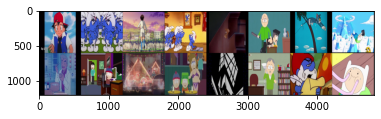


pokemon smurfs Tsubasa smurfs tom_and_jerry southpark tom_and_jerry adventure_time pokemon southpark Gumball southpark catdog southpark smurfs adventure_time


In [15]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels, paths = dataiter.next()

batch_size = 16

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print()
labels = labels.tolist()
print(' '.join(f'{list(classes.keys())[list(classes.values()).index(j)]}' for j in labels))

## Define a Convolutional Neural Network

Modified https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

In [16]:
class BottleNeck(nn.Module):
    expansion = 4
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()

        self.residual_function = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels * BottleNeck.expansion, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channels * BottleNeck.expansion),
        )

        self.shortcut = nn.Sequential()

        self.relu = nn.ReLU()

        if stride != 1 or in_channels != out_channels * BottleNeck.expansion:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels*BottleNeck.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels*BottleNeck.expansion)
            )
            
    def forward(self, x):
        x = self.residual_function(x) + self.shortcut(x)
        x = self.relu(x)
        return x

In [17]:
class ResNet(nn.Module):
    def __init__(self, block, num_block, num_classes=10, init_weights=True):
        super().__init__()

        self.in_channels=64

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

        self.conv2_x = self._make_layer(block, 64, num_block[0], 1)
        self.conv3_x = self._make_layer(block, 128, num_block[1], 2)
        self.conv4_x = self._make_layer(block, 256, num_block[2], 2)
        self.conv5_x = self._make_layer(block, 512, num_block[3], 2)

        self.avg_pool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        # weights inittialization
        if init_weights:
            self._initialize_weights()

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion

        return nn.Sequential(*layers)

    def forward(self,x):
        output = self.conv1(x)
        output = self.conv2_x(output)
        x = self.conv3_x(output)
        x = self.conv4_x(x)
        x = self.conv5_x(x)
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

    # define weight initialization function
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

def resnet50():
    return ResNet(BottleNeck, [3,4,6,3])

def resnet101():
    return ResNet(BottleNeck, [3, 4, 23, 3])

def resnet152():
    return ResNet(BottleNeck, [3, 8, 36, 3])

In [15]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 3) # in_channel, out_channel, kernel size
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 3, 5)
        self.fc1 = nn.Linear(64827, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 10)
        # self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [38]:
# Depthwise Separable Convolution
class Depthwise(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()

        self.depthwise = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, 3, stride=stride, padding=1, groups=in_channels, bias=False),
            nn.BatchNorm2d(in_channels),
            nn.ReLU6(),
        )

        self.pointwise = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU6()
        )
    
    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        return x


In [39]:
# Basic Conv2d
class BasicConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, **kwargs):
        super().__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, **kwargs),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.conv(x)
        return x

In [40]:
# MobileNetV1
class MobileNet(nn.Module):
    def __init__(self, width_multiplier, num_classes=10, init_weights=True):
        super().__init__()
        self.init_weights=init_weights
        alpha = width_multiplier

        self.conv1 = BasicConv2d(3, int(32*alpha), 3, stride=2, padding=1)
        self.conv2 = Depthwise(int(32*alpha), int(64*alpha), stride=1)
        # down sample
        self.conv3 = nn.Sequential(
            Depthwise(int(64*alpha), int(128*alpha), stride=2),
            Depthwise(int(128*alpha), int(128*alpha), stride=1)
        )
        # down sample
        self.conv4 = nn.Sequential(
            Depthwise(int(128*alpha), int(256*alpha), stride=2),
            Depthwise(int(256*alpha), int(256*alpha), stride=1)
        )
        # down sample
        self.conv5 = nn.Sequential(
            Depthwise(int(256*alpha), int(512*alpha), stride=2),
            Depthwise(int(512*alpha), int(512*alpha), stride=1),
            Depthwise(int(512*alpha), int(512*alpha), stride=1),
            Depthwise(int(512*alpha), int(512*alpha), stride=1),
            Depthwise(int(512*alpha), int(512*alpha), stride=1),
            Depthwise(int(512*alpha), int(512*alpha), stride=1),
        )
        # down sample
        self.conv6 = nn.Sequential(
            Depthwise(int(512*alpha), int(1024*alpha), stride=2)
        )
        # down sample
        self.conv7 = nn.Sequential(
            Depthwise(int(1024*alpha), int(1024*alpha), stride=2)
        )

        self.avg_pool = nn.AdaptiveAvgPool2d((1,1))
        self.linear = nn.Linear(int(1024*alpha), num_classes)

        # weights initialization
        if self.init_weights:
            self._initialize_weights()

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.conv6(x)
        x = self.conv7(x)
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.linear(x)
        return x

    # weights initialization function
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

def mobilenet(alpha=1, num_classes=10):
    return MobileNet(alpha, num_classes)

In [37]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # Use GPU if it's available


In [41]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()

In [42]:
#mobilenet
net = mobilenet(alpha=1).to(device)

In [ ]:
#resnet
net = resnet152().to(device)

In [17]:
#baseline
net = Net() # define the network
net = net.to(device) # send the network to the device

## Define a Loss function and optimizer

In [43]:
criterion = nn.CrossEntropyLoss() # loss function
#optimizer
optimizer = optim.Adam(net.parameters(),lr=0.05,betas=(0.9,0.999),eps=1e-08,weight_decay=0)
# optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9) 

## Train the Network

In [ ]:
for epoch in range(1):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(tqdm(train_loader, 0)):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels, paths = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training') # colab pro+ 기준, 한 epoch 당 35분 소요

  0%|          | 0/7477 [00:00<?, ?it/s]

## Save the Network

In [23]:
# save the trained model
PATH = './net.pth'
torch.save(net.state_dict(), PATH)

## Load the Network

In [24]:
# net = Net()
# net.load_state_dict(torch.load(PATH))

## Testing & Making a Submission File

In [31]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs

image_id = []
predicted_label = []
with torch.no_grad():
    for i, data in enumerate(tqdm(test_loader,0)):
        images, labels, paths = data
        images = images.to(device)
        labels = labels.to(device)
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        ₩
        image_id.append(paths)
        predicted_label.append(predicted.item())

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the {len(test_loader.dataset)} test images: {100 * correct // total} %')

  0%|          | 0/18110 [00:00<?, ?it/s]

Accuracy of the network on the 18110 test images: 20 %


In [26]:
submit_sol = pd.DataFrame(list(zip(image_id, predicted_label)), columns=['id','predicted'])

In [27]:
submit_sol

,id,predicted
0,(./cartoon_classification/TEST/Familyguy/famil...,5
1,(./cartoon_classification/TEST/Familyguy/famil...,3
2,(./cartoon_classification/TEST/Familyguy/famil...,3
3,(./cartoon_classification/TEST/Familyguy/famil...,3
4,(./cartoon_classification/TEST/Familyguy/famil...,3
...,...,...
18105,(./cartoon_classification/TEST/tom_and_jerry/T...,5
18106,(./cartoon_classification/TEST/tom_and_jerry/T...,5
18107,(./cartoon_classification/TEST/tom_and_jerry/T...,5
18108,(./cartoon_classification/TEST/tom_and_jerry/T...,5


In [28]:
import os

def clean_path(path):
  cleaned_path = os.path.normpath(path)
  cleaned_path = path.split(os.sep)
  new_path = cleaned_path[3] +'/' + cleaned_path[4] # cartoon name/xx.jpg
  return new_path

In [29]:
path_list = []
for i in range(len(submit_sol)):
  out = clean_path(submit_sol.iloc[i][0][0])
  path_list.append(out)

submit_sol['id'] = path_list

In [30]:
submit_sol.to_csv('test_result.csv', index=False)  # submit this test_result.csv to kaggle server